## boring stuff

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
# import category_encoders as cat_ed
import gc, mlcrate, glob

# from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from IPython.display import display

from catboost import CatBoostRegressor
from scipy.cluster import hierarchy as hc
from collections import Counter

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd()
PATH

'D:\\Github\\fastai\\courses\\ml1\\AV_Enigma_ML'

In [5]:
df_raw = pd.read_csv(f'{PATH}\\train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\test.csv', low_memory=False)
target = np.load(f'{PATH}\\target.npy')

In [6]:
df_raw.shape, df_test.shape, len(target)

((330045, 7), (141448, 6), 330045)

In [7]:
man_train_list = df_raw.Username.unique()
man_test_list = df_test.Username.unique()
print("Train: {0}".format(len(man_train_list)))
print("Test: {0}".format(len(man_test_list)))

man_not_in_test = set(man_train_list) - set(man_test_list)
man_not_in_train = set(man_test_list) - set(man_train_list)

print("${}$ Users are featured in train but not in test".format(len(man_not_in_test)))
print("${}$ Users are featured in test but not in train".format(len(man_not_in_train)))

Train: 141802
Test: 79351
$96388$ Users are featured in train but not in test
$33937$ Users are featured in test but not in train


In [8]:
df_raw.shape, df_raw.drop(index = df_raw.loc[list(man_not_in_test)].index, inplace=True), df_raw.shape

((330045, 7), None, (233657, 7))

In [9]:
print('Initial ', df_raw.shape, df_test.shape)

bin_cols = ['Answers', 'Views', 'Reputation']

for col in bin_cols:
    
    ulimit = np.percentile(df_raw[col],99)
    llimit = np.percentile(df_raw[col],1)
    df_raw.drop(index=df_raw[col].ix[df_raw[col]>ulimit].index, inplace=True)
    df_raw.drop(index=df_raw[col].ix[df_raw[col]<llimit].index, inplace=True)
    
print('Final ', df_raw.shape, df_test.shape)

Initial  (233657, 7) (141448, 6)
Final  (223134, 7) (141448, 6)


In [10]:
df_raw.drop(index= df_raw[(df_raw['Reputation'] == 0) & (df_raw['Answers'] !=0)].index, inplace=True)

In [11]:
df_raw.shape, df_test.shape

((218673, 7), (141448, 6))

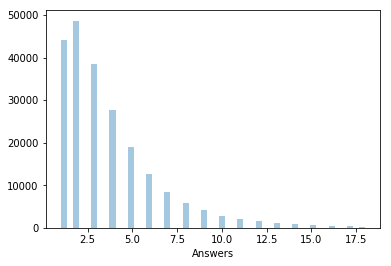

In [12]:
sns.distplot(df_raw['Answers'], kde=False)

In [13]:
target = df_raw.Upvotes.values

In [14]:
np.mean(target)

178.53712163824522

In [15]:
df_test.shape

(141448, 6)

In [16]:
mean_preds = np.full_like(df_test['Username'], 178)

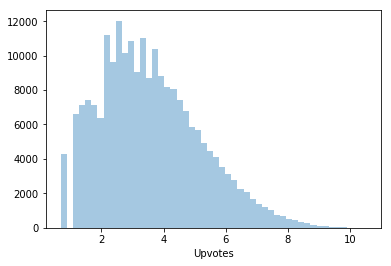

In [17]:
# ulimit = np.percentile(target,99)
# llimit = np.percentile(target,1)
# df_raw['Upvotes'].ix[df_raw['Upvotes']>ulimit] = ulimit
# df_raw['Upvotes'].ix[df_raw['Upvotes']<llimit] = llimit
sns.distplot(np.log(df_raw['Upvotes'] + 2), bins = 50, kde=False)

In [18]:
def display_all(df):
    with pd.option_context("display.max_rows", 100): 
        with pd.option_context("display.max_columns", 100): 
            display(df)

def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\sample_submission.csv')
    submit = sample.copy()
    submit['Upvotes'] = probs
    return submit

## fe's

In [19]:
xyz = pd.concat([df_raw.groupby('Username').mean(),df_raw.groupby('Username').count()], axis = 1).iloc[:,:-5]
xyz.columns = ['ID', 'Reputation', 'Answers', 'Views', 'Upvotes', 'count']
############################################################################################# Mean Aggs

df_raw_feats = pd.DataFrame()
df_raw_feats['Username'] = df_raw['Username'].copy()
df_raw_feats['Tag']      = df_raw['Tag'].copy()
df_raw_feats['Reputation'] = df_raw['Reputation'].copy()
df_raw_feats['Answers']    = df_raw['Answers'].copy()

unames   = xyz.sort_values(by = 'count', ascending = False).reset_index()['Username'].values
count    = xyz.sort_values(by = 'count', ascending = False).reset_index()['count'].values
answers  = xyz.sort_values(by = 'count', ascending = False).reset_index()['Answers'].values
views    = xyz.sort_values(by = 'count', ascending = False).reset_index()['Views'].values
repo     = xyz.sort_values(by = 'count', ascending = False).reset_index()['Reputation'].values 

d = {}
for idx,k in enumerate(unames):
    d[k] = count[idx]
df_raw_feats['agg_count'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = answers[idx]
df_raw_feats['agg_answers'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = views[idx]
df_raw_feats['agg_views'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = repo[idx]
df_raw_feats['agg_repo'] = df_raw['Username'].map(d)

In [20]:
xyz = pd.concat([df_test.groupby('Username').mean(),df_test.groupby('Username').count()], axis = 1).iloc[:,:-4]
xyz.columns = ['ID', 'Reputation', 'Answers', 'Views', 'count']

########################################################################################## Mean Aggregates

df_test_feats = pd.DataFrame()
df_test_feats['Username'] = df_test['Username'].copy()
df_test_feats['Tag']      = df_test['Tag'].copy()
df_test_feats['Reputation'] = df_test['Reputation'].copy()
df_test_feats['Answers']    = df_test['Answers']

unames   = xyz.sort_values(by = 'count', ascending = False).reset_index()['Username'].values
count    = xyz.sort_values(by = 'count', ascending = False).reset_index()['count'].values
answers  = xyz.sort_values(by = 'count', ascending = False).reset_index()['Answers'].values
views    = xyz.sort_values(by = 'count', ascending = False).reset_index()['Views'].values
repo     = xyz.sort_values(by = 'count', ascending = False).reset_index()['Reputation'].values 

d = {}
for idx,k in enumerate(unames):
    d[k] = count[idx]
df_test_feats['agg_count'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = answers[idx]
df_test_feats['agg_answers'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = views[idx]
df_test_feats['agg_views'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = repo[idx]
df_test_feats['agg_repo'] = df_test['Username'].map(d)

In [21]:
df_raw_feats.head()

,Username,Tag,Reputation,Answers,agg_count,agg_answers,agg_views,agg_repo
4,112223,c,4271.0,4.0,3,2.00,20598.666667,4271.0
7,54623,j,2269.0,2.0,4,2.00,6063.750000,2269.0
8,172926,j,111.0,2.0,1,2.00,53738.000000,111.0
15,62155,c,7952.0,2.0,4,3.75,28314.750000,7952.0
16,43559,i,731.0,4.0,2,2.50,6730.500000,731.0


In [22]:
df_raw['Username'].min(), df_test['Username'].min()

(3, 4)

In [23]:
add_trans = ['Reputation', 'Answers', 'Views']

for col in add_trans:
    
    df_raw_feats[f'log_trans_{col}'.format(col)]  = np.log(df_raw[col] + 1) #avoid log 0's if any
    df_test_feats[f'log_trans_{col}'.format(col)] = np.log(df_test[col] + 1) #avoid log 0's if any
    df_raw_feats[f'sqrt_trans_{col}'.format(col)]  = np.sqrt(df_raw[col])
    df_test_feats[f'sqrt_trans_{col}'.format(col)] = np.sqrt(df_test[col])
    
df_raw_feats['repo_per_Answers'] = df_raw['Reputation'] / (df_raw['Answers']+1)
df_raw_feats['repo_per_Views']   = df_raw['Reputation'] / df_raw['Views']
df_raw_feats['log_trans_repo_per_Answers'] = np.log(df_raw_feats['repo_per_Answers'] + 1)
df_raw_feats['log_trans_repo_per_Views']   = np.log(df_raw_feats['repo_per_Views'] + 1)

df_test_feats['repo_per_Answers'] = df_test['Reputation'] / (df_test['Answers'] +1)
df_test_feats['repo_per_Views']   = df_test['Reputation'] / df_test['Views']
df_test_feats['log_trans_repo_per_Answers'] = np.log(df_test_feats['repo_per_Answers'] + 1)
df_test_feats['log_trans_repo_per_Views']   = np.log(df_test_feats['repo_per_Views'] + 1)

df_raw.shape, df_test.shape, df_raw_feats.shape, df_test_feats.shape

((218673, 7), (141448, 6), (218673, 18), (141448, 18))

In [24]:
unames_trn  = df_raw[['Username','Tag']].groupby('Username')['Tag'].nunique().reset_index()['Username'].values
unames_test = df_test[['Username','Tag']].groupby('Username')['Tag'].nunique().reset_index()['Username'].values

tag_trn     = df_raw[['Username','Tag']].groupby('Username')['Tag'].nunique().reset_index()['Tag'].values
tag_test    = df_test[['Username','Tag']].groupby('Username')['Tag'].nunique().reset_index()['Tag'].values

In [25]:
d = {}
for idx,k in enumerate(unames_trn):
    d[k] = tag_trn[idx]
df_raw_feats['unique_tag'] = df_raw['Username'].map(d)

In [26]:
d = {}
for idx,k in enumerate(unames_test):
    d[k] = tag_test[idx]
df_test_feats['unique_tag'] = df_test['Username'].map(d)

In [27]:
def get_score(l = []):
    score = 1
    for i in l:
        if i == 'c': score += 10
        if i == 'j': score += 9
        if i == 'p': score += 8
        if i == 'i': score += 7
        if i == 'a': score += 6
        if i == 's': score += 5
        if i == 'h': score += 4
        if i == 'o': score += 3
        if i == 'r': score += 2
    return(score)

In [28]:
%%time
import gc

d = {}

for i in unames_trn[::-1]:
    d[i] = set(df_raw_feats[df_raw_feats['Username'] == i]['Tag'].values)

for k,v in d.items():
    l = []
    for i in v:
        l.append(i)
    d[k] = get_score(l)
    
df_raw_feats['skill_score'] = df_raw_feats['Username'].map(d)
del d
gc.collect()

Wall time: 1min 25s


In [29]:
%%time

d = {}

for i in unames_test[::-1]:
    d[i] = set(df_test_feats[df_test_feats['Username'] == i]['Tag'].values)

for k,v in d.items():
    l = []
    for i in v:
        l.append(i)
    d[k] = get_score(l)
    
df_test_feats['skill_score'] = df_test_feats['Username'].map(d)
del d
gc.collect()

Wall time: 57.2 s


In [30]:
df_raw_feats['rep_per_skill'] = df_raw['Reputation']/ df_raw_feats['skill_score']
df_raw_feats['skill_per_tag'] = df_raw_feats['skill_score']/ df_raw_feats['unique_tag']
df_raw_feats['views_per_ans'] = df_raw['Views'] / (df_raw['Answers']+ 1)

df_test_feats['rep_per_skill'] = df_test['Reputation']/ df_test_feats['skill_score']
df_test_feats['skill_per_tag'] = df_test_feats['skill_score']/ df_test_feats['unique_tag']
df_test_feats['views_per_ans'] = df_test['Views'] / (df_test['Answers']+ 1)

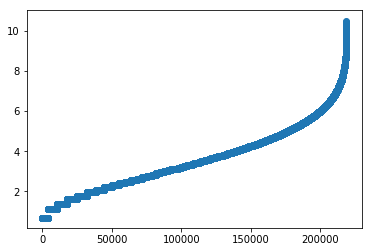

In [31]:
plt.scatter(range(df_raw.shape[0]), np.sort(np.log(target+2)))

In [31]:
df_raw_feats.to_csv(f'{PATH}\\new_feats_train.csv', index=None)
df_test_feats.to_csv(f'{PATH}\\new_feats_test.csv', index=None)

In [56]:
bins = [0, 1, 5, 10, 25, 50, 75, 100]
labels = [i+1 for i in range(len(bins) - 1)]
bin_cols = ['Answers', 'Views', 'Reputation']

for col in bin_cols:
    
    df_raw_feats[f'bin_{col}'.format(col)]  = pd.cut(np.log(df_raw[col]+2) ,bins,labels = labels)
    df_test_feats[f'bin_{col}'.format(col)] = pd.cut(np.log(df_test[col]+2),bins,labels = labels)

In [32]:
df_raw_feats['Tag'] = df_raw_feats['Tag'].astype('category')
df_test_feats['Tag'] = df_test_feats['Tag'].astype('category')
#couldhave ued hstack as well...

In [57]:
df_raw_feats.get_ftype_counts(), df_test_feats.get_ftype_counts()

(category:dense     4
 float64:dense     18
 int64:dense        4
 dtype: int64, category:dense     4
 float64:dense     18
 int64:dense        4
 dtype: int64)

## cat

In [35]:
target

array([ 83.,   3.,  79., ...,  15.,   3.,  37.])

In [43]:
model=CatBoostRegressor(iterations=300, learning_rate= 0.06, depth = 6, loss_function='RMSE', )

In [42]:
df_raw_feats.shape, df_test_feats.shape, len(target)

((218673, 23), (141448, 23), 218673)

In [45]:
model.fit(df_raw_feats, target,cat_features=[1,23,24,25], eval_set=(X_valid,y_valid))

0:	learn: 703.8471019	test: 682.6249252	best: 682.6249252 (0)	total: 548ms	remaining: 2m 43s
1:	learn: 672.5308812	test: 651.1666595	best: 651.1666595 (1)	total: 882ms	remaining: 2m 11s
2:	learn: 643.4066737	test: 622.4667526	best: 622.4667526 (2)	total: 1.19s	remaining: 1m 58s
3:	learn: 615.8537990	test: 594.8685878	best: 594.8685878 (3)	total: 1.5s	remaining: 1m 50s
4:	learn: 589.7438175	test: 568.9457332	best: 568.9457332 (4)	total: 1.79s	remaining: 1m 45s
5:	learn: 566.2221813	test: 545.9714116	best: 545.9714116 (5)	total: 2.1s	remaining: 1m 42s
6:	learn: 543.4251945	test: 523.0799118	best: 523.0799118 (6)	total: 2.38s	remaining: 1m 39s
7:	learn: 522.4063688	test: 502.0610424	best: 502.0610424 (7)	total: 2.68s	remaining: 1m 37s
8:	learn: 502.8170426	test: 482.7275196	best: 482.7275196 (8)	total: 2.97s	remaining: 1m 35s
9:	learn: 484.6759434	test: 464.8838477	best: 464.8838477 (9)	total: 3.25s	remaining: 1m 34s
10:	learn: 467.9196239	test: 447.9175123	best: 447.9175123 (10)	total: 3

87:	learn: 244.6063352	test: 229.8471490	best: 229.8471490 (87)	total: 26.7s	remaining: 1m 4s
88:	learn: 244.4177743	test: 229.7869610	best: 229.7869610 (88)	total: 27s	remaining: 1m 4s
89:	learn: 244.1910617	test: 229.6759892	best: 229.6759892 (89)	total: 27.3s	remaining: 1m 3s
90:	learn: 243.9311714	test: 229.3977660	best: 229.3977660 (90)	total: 27.6s	remaining: 1m 3s
91:	learn: 243.7761203	test: 229.2309928	best: 229.2309928 (91)	total: 27.9s	remaining: 1m 3s
92:	learn: 243.6497151	test: 229.0841055	best: 229.0841055 (92)	total: 28.2s	remaining: 1m 2s
93:	learn: 243.4405010	test: 228.8590694	best: 228.8590694 (93)	total: 28.6s	remaining: 1m 2s
94:	learn: 243.3689393	test: 228.7707776	best: 228.7707776 (94)	total: 28.9s	remaining: 1m 2s
95:	learn: 243.1082827	test: 228.4895154	best: 228.4895154 (95)	total: 29.3s	remaining: 1m 2s
96:	learn: 242.8310790	test: 228.2321103	best: 228.2321103 (96)	total: 29.7s	remaining: 1m 2s
97:	learn: 242.4174373	test: 228.0814205	best: 228.0814205 (97

174:	learn: 232.8525584	test: 220.9548305	best: 220.9548305 (174)	total: 55.5s	remaining: 39.7s
175:	learn: 232.7659506	test: 220.9323946	best: 220.9323946 (175)	total: 55.9s	remaining: 39.4s
176:	learn: 232.7018645	test: 220.8800656	best: 220.8800656 (176)	total: 56.2s	remaining: 39.1s
177:	learn: 232.6389600	test: 220.8466965	best: 220.8466965 (177)	total: 56.6s	remaining: 38.8s
178:	learn: 232.5514346	test: 220.7513208	best: 220.7513208 (178)	total: 57s	remaining: 38.5s
179:	learn: 232.5514030	test: 220.7508874	best: 220.7508874 (179)	total: 57.2s	remaining: 38.1s
180:	learn: 232.3801144	test: 220.5063198	best: 220.5063198 (180)	total: 57.5s	remaining: 37.8s
181:	learn: 232.3791318	test: 220.5068594	best: 220.5063198 (180)	total: 57.7s	remaining: 37.4s
182:	learn: 232.1946698	test: 220.3536719	best: 220.3536719 (182)	total: 58s	remaining: 37.1s
183:	learn: 232.1075335	test: 220.3413159	best: 220.3413159 (183)	total: 58.4s	remaining: 36.8s
184:	learn: 232.0683413	test: 220.2732370	be

260:	learn: 226.6111276	test: 215.6717626	best: 215.6717626 (260)	total: 1m 24s	remaining: 12.6s
261:	learn: 226.6044048	test: 215.6641945	best: 215.6641945 (261)	total: 1m 24s	remaining: 12.2s
262:	learn: 226.6026261	test: 215.6650369	best: 215.6641945 (261)	total: 1m 24s	remaining: 11.9s
263:	learn: 226.5392439	test: 215.6278132	best: 215.6278132 (263)	total: 1m 25s	remaining: 11.6s
264:	learn: 226.5250454	test: 215.6099406	best: 215.6099406 (264)	total: 1m 25s	remaining: 11.3s
265:	learn: 226.4558992	test: 215.5568794	best: 215.5568794 (265)	total: 1m 25s	remaining: 11s
266:	learn: 226.4314091	test: 215.5288649	best: 215.5288649 (266)	total: 1m 26s	remaining: 10.6s
267:	learn: 226.3725262	test: 215.4500588	best: 215.4500588 (267)	total: 1m 26s	remaining: 10.3s
268:	learn: 226.2675661	test: 215.2921497	best: 215.2921497 (268)	total: 1m 26s	remaining: 10s
269:	learn: 226.1717894	test: 215.1551096	best: 215.1551096 (269)	total: 1m 27s	remaining: 9.7s
270:	learn: 226.0944918	test: 215.0

In [265]:
model.save_model(f'{PATH}\\catboost_new_feats_model', export_parameters=dict())

In [46]:
preds = model.predict(df_test_feats);
preds[:10]

array([ 185.86597,  104.54369,   28.44292,   20.38781,  303.19668,   17.94036,   16.89321,   88.93819,
         52.39601,   16.89539])

In [59]:
np.mean(target), np.std(target), np.max(target)

(178.53712163824522, 715.88228024998364, 36374.0)

In [60]:
np.mean(preds), np.std(preds), np.max(preds)

(237.93752569435802, 1041.744052814126, 27649.059268086836)

In [64]:
clipped_preds = np.where(preds>15000,15000,preds )

In [65]:
submit = make_submission(clipped_preds)

In [66]:
submit.to_csv(f'{PATH}\\Adi_catboost_with_new_feats_10092018.csv', index=None)

## xgb

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(df_raw_feats,prefix='dummy'), target, test_size=0.25, random_state=42)

In [46]:
from sklearn.metrics import mean_squared_error as mse
def runXGB(train_X, train_y, test_X, test_y=None):
    
        params = {}
        params['booster'] = 'gblinear'
        params["objective"] = "gpu:reg:linear"
        params["eta"] = 0.02
        params["min_child_weight"] = 2
        params["subsample"] = 0.9
        params["colsample_bytree"] = 0.8
        params["silent"] = 0
        params["max_depth"] = 8
        params["seed"] = 1
        params['alpha'] = .05
        #params['tree_method'] = 'gpu_hist'
        params['gamma'] = 3
        
        plst = list(params.items())
        num_rounds = 900

        xgtrain = xgb.DMatrix(train_X, label=train_y)
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        pred_test_y = model.predict(xgtest)
        return model, pred_test_y

def rmse(act_y, pred_y):
    return np.sqrt(mse(act_y, pred_y))

In [47]:
model_xgb, preds = runXGB(pd.get_dummies(df_raw_feats,prefix='dummy'), target, pd.get_dummies(df_test_feats,prefix='dummy'))

In [48]:
preds

array([ 372.51456,  614.90576,  214.76334, ...,  177.34044,    5.16377,   58.18262], dtype=float32)

In [49]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\xgb_gblinear_preds.csv', index=None)

In [290]:
import joblib

In [291]:
joblib.dump(my_xgb, f'{PATH}\\xgb_model')

['D:\\Github\\fastai\\courses\\ml1\\AV_Enigma_ML\\xgb_model']

In [292]:
xgb_model_load = joblib.load(f'{PATH}\\xgb_model')

In [293]:
xgb_model_load.feature_importances_

array([ 0.02511,  0.01012,  0.01531,  0.01939,  0.039  ,  0.34472,  0.02941,  0.0075 ,  0.00027,  0.00417,
        0.00018,  0.37205,  0.02329,  0.0134 ,  0.02684,  0.00262,  0.00364,  0.00155,  0.00421,  0.01442,
        0.00705,  0.01721,  0.00342,  0.00013,  0.00266,  0.00031,  0.00164,  0.00031,  0.00262,  0.00324,
        0.00164,  0.00075,  0.00067,  0.00115], dtype=float32)

## NN

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

In [127]:
df_raw_feats_dummy = pd.get_dummies(df_raw_feats.drop(['bin_Reputation','bin_Views','bin_Answers'],axis=1),prefix='dummy')
df_test_feats_dummy = pd.get_dummies(df_test_feats.drop(['bin_Reputation','bin_Views','bin_Answers'],axis=1),prefix='dummy')

In [142]:
df_raw_feats_dummy.shape, df_test_feats_dummy.shape

((218673, 32), (141448, 32))

In [155]:
scaler = StandardScaler()
scaler.fit(df_raw_feats_dummy)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [161]:
X_train = scaler.fit_transform(df_raw_feats_dummy)
X_test = scaler.transform(df_test_feats_dummy)

In [168]:
model = Sequential()
model.add(Dense(100, input_dim=df_raw_feats_dummy.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

In [169]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 9,183
Trainable params: 9,183
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['mae'])

In [171]:
model.fit(X_train, np.log(target+2), 64, validation_split=0.2)

Train on 174938 samples, validate on 43735 samples
Epoch 1/10


 42304/174938 [======>.......................] - ETA: 1077s - loss: 16.7450 - mean_absolute_error: 3.631 - ETA: 170s - loss: 9.5557 - mean_absolute_error: 2.6167  - ETA: 96s - loss: 6.3488 - mean_absolute_error: 1.918 - ETA: 73s - loss: 4.8702 - mean_absolute_error: 1.64 - ETA: 62s - loss: 3.9035 - mean_absolute_error: 1.43 - ETA: 55s - loss: 3.3155 - mean_absolute_error: 1.30 - ETA: 50s - loss: 2.8769 - mean_absolute_error: 1.20 - ETA: 48s - loss: 2.6435 - mean_absolute_error: 1.14 - ETA: 44s - loss: 2.4108 - mean_absolute_error: 1.09 - ETA: 41s - loss: 2.1664 - mean_absolute_error: 1.02 - ETA: 40s - loss: 2.0341 - mean_absolute_error: 0.99 - ETA: 40s - loss: 1.9350 - mean_absolute_error: 0.97 - ETA: 39s - loss: 1.8478 - mean_absolute_error: 0.94 - ETA: 38s - loss: 1.7663 - mean_absolute_error: 0.92 - ETA: 37s - loss: 1.7033 - mean_absolute_error: 0.91 - ETA: 37s - loss: 1.6338 - mean_absolute_error: 0.89 - ETA: 36s - loss: 1.5816 - mean_absolute_error: 0.88 - ETA: 36s - loss: 1.5368 

165472/174938 [===========================>..] - ETA: 9s - loss: 0.5531 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5527 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5527 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5525 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5522 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5521 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5519 - mean_absolute_error: 0.549 - ETA: 9s - loss: 0.5518 - mean_absolute_error: 0.549 - ETA: 8s - loss: 0.5515 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5511 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5507 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5508 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5506 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5504 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5501 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5498 - mean_absolute_error: 0.548 - ETA: 8s - loss: 0.5496 - mean_absolute_error: 0.547 - ETA: 8s - loss: 0.5493 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.5311 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5310 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5308 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5305 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5304 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5305 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5305 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5305 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5303 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5302 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5301 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5301 - mean_absolute_error: 0.538 - ETA: 1s - loss: 0.5298 - mean_absolute_error: 0.537 - ETA: 1s - loss: 0.5297 - mean_absolute_error: 0.537 - ETA: 1s - loss: 0.5294 - mean_absolute_error: 0.537 - ETA: 0s - loss: 0.5292 - mean_absolute_error: 0.537 - ETA: 0s - loss: 0.5291 - mean_absolute_error: 0.537 - ETA: 0s - loss: 0.5289 - mean_abs

 41728/174938 [======>.......................] - ETA: 109s - loss: 0.2824 - mean_absolute_error: 0.398 - ETA: 51s - loss: 0.3855 - mean_absolute_error: 0.473 - ETA: 43s - loss: 0.4357 - mean_absolute_error: 0.48 - ETA: 41s - loss: 0.4413 - mean_absolute_error: 0.49 - ETA: 38s - loss: 0.4798 - mean_absolute_error: 0.50 - ETA: 36s - loss: 0.4941 - mean_absolute_error: 0.51 - ETA: 34s - loss: 0.4873 - mean_absolute_error: 0.50 - ETA: 36s - loss: 0.4752 - mean_absolute_error: 0.50 - ETA: 34s - loss: 0.4710 - mean_absolute_error: 0.50 - ETA: 33s - loss: 0.4661 - mean_absolute_error: 0.50 - ETA: 33s - loss: 0.4661 - mean_absolute_error: 0.50 - ETA: 32s - loss: 0.4785 - mean_absolute_error: 0.50 - ETA: 32s - loss: 0.4836 - mean_absolute_error: 0.51 - ETA: 32s - loss: 0.4888 - mean_absolute_error: 0.51 - ETA: 32s - loss: 0.4826 - mean_absolute_error: 0.51 - ETA: 31s - loss: 0.4876 - mean_absolute_error: 0.51 - ETA: 31s - loss: 0.4828 - mean_absolute_error: 0.51 - ETA: 30s - loss: 0.4824 - mean

166784/174938 [===========================>..] - ETA: 9s - loss: 0.4590 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4590 - mean_absolute_error: 0.500 - ETA: 9s - loss: 0.4591 - mean_absolute_error: 0.500 - ETA: 9s - loss: 0.4589 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4588 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4586 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4585 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4584 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4583 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4582 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4581 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4582 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4582 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4582 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4581 - mean_absolute_error: 0.499 - ETA: 9s - loss: 0.4581 - mean_absolute_error: 0.499 - ETA: 8s - loss: 0.4584 - mean_absolute_error: 0.499 - ETA: 8s - loss: 0.4582 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.4556 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4555 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4555 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4557 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4557 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4555 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4553 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4554 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4552 - mean_absolute_error: 0.497 - ETA: 1s - loss: 0.4553 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4553 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4554 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4555 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4558 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4558 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4559 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4559 - mean_absolute_error: 0.497 - ETA: 0s - loss: 0.4559 - mean_abs

 43904/174938 [======>.......................] - ETA: 152s - loss: 0.5236 - mean_absolute_error: 0.600 - ETA: 48s - loss: 0.5297 - mean_absolute_error: 0.548 - ETA: 37s - loss: 0.4858 - mean_absolute_error: 0.52 - ETA: 34s - loss: 0.4614 - mean_absolute_error: 0.51 - ETA: 33s - loss: 0.4746 - mean_absolute_error: 0.51 - ETA: 31s - loss: 0.4709 - mean_absolute_error: 0.50 - ETA: 30s - loss: 0.4554 - mean_absolute_error: 0.49 - ETA: 31s - loss: 0.4533 - mean_absolute_error: 0.49 - ETA: 33s - loss: 0.4572 - mean_absolute_error: 0.49 - ETA: 32s - loss: 0.4593 - mean_absolute_error: 0.49 - ETA: 32s - loss: 0.4559 - mean_absolute_error: 0.49 - ETA: 32s - loss: 0.4525 - mean_absolute_error: 0.49 - ETA: 31s - loss: 0.4464 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4526 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4490 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4516 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4577 - mean_absolute_error: 0.49 - ETA: 31s - loss: 0.4592 - mean

170624/174938 [============================>.] - ETA: 8s - loss: 0.4471 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4472 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4471 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4472 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4473 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4474 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4475 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4478 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4480 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4480 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4478 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4477 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4478 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4479 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4477 - mean_absolute_error: 0.490 - ETA: 8s - loss: 0.4475 - mean_absolute_error: 0.490 - ETA: 7s - loss: 0.4475 - mean_absolute_error: 0.490 - ETA: 7s - loss: 0.4474 - mean_abs

174938/174938 [==============================] - ETA: 0s - loss: 0.4458 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4458 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4460 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4459 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4458 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4456 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4457 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4458 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4457 - mean_absolute_error: 0.489 - ETA: 0s - loss: 0.4456 - mean_absolute_error: 0.488 - 37s - loss: 0.4457 - mean_absolute_error: 0.4889 - val_loss: 0.4900 - val_mean_absolute

 43488/174938 [======>.......................] - ETA: 152s - loss: 0.8365 - mean_absolute_error: 0.704 - ETA: 62s - loss: 0.6801 - mean_absolute_error: 0.597 - ETA: 44s - loss: 0.5889 - mean_absolute_error: 0.54 - ETA: 37s - loss: 0.5112 - mean_absolute_error: 0.50 - ETA: 34s - loss: 0.5261 - mean_absolute_error: 0.51 - ETA: 31s - loss: 0.5151 - mean_absolute_error: 0.50 - ETA: 31s - loss: 0.5058 - mean_absolute_error: 0.50 - ETA: 30s - loss: 0.4949 - mean_absolute_error: 0.50 - ETA: 29s - loss: 0.4979 - mean_absolute_error: 0.50 - ETA: 30s - loss: 0.4900 - mean_absolute_error: 0.50 - ETA: 29s - loss: 0.4835 - mean_absolute_error: 0.49 - ETA: 29s - loss: 0.4758 - mean_absolute_error: 0.49 - ETA: 29s - loss: 0.4698 - mean_absolute_error: 0.49 - ETA: 29s - loss: 0.4701 - mean_absolute_error: 0.49 - ETA: 29s - loss: 0.4642 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4672 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4656 - mean_absolute_error: 0.49 - ETA: 30s - loss: 0.4700 - mean

164672/174938 [===========================>..] - ETA: 9s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4423 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 9s - loss: 0.4423 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4422 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4421 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4425 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4425 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4423 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4425 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4425 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 8s - loss: 0.4425 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.4422 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4424 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 1s - loss: 0.4424 - mean_absolute_error: 0.486 - ETA: 1s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 1s - loss: 0.4427 - mean_absolute_error: 0.486 - ETA: 1s - loss: 0.4426 - mean_absolute_error: 0.486 - ETA: 1s - loss: 0.4424 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4423 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4422 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4421 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4420 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4422 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4422 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4422 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4423 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4423 - mean_absolute_error: 0.485 - ETA: 1s - loss: 0.4421 - mean_abs

 39648/174938 [=====>........................] - ETA: 87s - loss: 0.5102 - mean_absolute_error: 0.49 - ETA: 41s - loss: 0.4546 - mean_absolute_error: 0.46 - ETA: 38s - loss: 0.4403 - mean_absolute_error: 0.47 - ETA: 37s - loss: 0.4326 - mean_absolute_error: 0.47 - ETA: 37s - loss: 0.4188 - mean_absolute_error: 0.46 - ETA: 37s - loss: 0.4198 - mean_absolute_error: 0.47 - ETA: 36s - loss: 0.4133 - mean_absolute_error: 0.47 - ETA: 36s - loss: 0.4068 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.4061 - mean_absolute_error: 0.47 - ETA: 36s - loss: 0.4014 - mean_absolute_error: 0.47 - ETA: 36s - loss: 0.3968 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.3971 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.4016 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.3994 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.4003 - mean_absolute_error: 0.46 - ETA: 36s - loss: 0.4003 - mean_absolute_error: 0.46 - ETA: 37s - loss: 0.3999 - mean_absolute_error: 0.46 - ETA: 37s - loss: 0.4047 - mean_ab

160416/174938 [==========================>...] - ETA: 10s - loss: 0.4412 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4413 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4415 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4414 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4412 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4411 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4412 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4411 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4414 - mean_absolute_error: 0.48 - ETA: 9s - loss: 0.4413 - mean_absolute_error: 0.4851 - ETA: 9s - loss: 0.4414 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4414 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4413 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4414 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4411 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4411 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4409 - mean_absolute_error: 0.485 - ETA: 9s - loss: 0.4410 - mean_ab

174938/174938 [==============================] - ETA: 2s - loss: 0.4403 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4403 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4404 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4402 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4402 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4401 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4401 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4399 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4400 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4399 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4397 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4396 - mean_absolute_error: 0.484 - ETA: 2s - loss: 0.4398 - mean_abs

 40896/174938 [======>.......................] - ETA: 109s - loss: 0.3577 - mean_absolute_error: 0.478 - ETA: 39s - loss: 0.3437 - mean_absolute_error: 0.441 - ETA: 42s - loss: 0.3593 - mean_absolute_error: 0.45 - ETA: 39s - loss: 0.3591 - mean_absolute_error: 0.45 - ETA: 37s - loss: 0.3861 - mean_absolute_error: 0.47 - ETA: 37s - loss: 0.3933 - mean_absolute_error: 0.47 - ETA: 36s - loss: 0.4112 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4120 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4182 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4219 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4134 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4088 - mean_absolute_error: 0.47 - ETA: 35s - loss: 0.4022 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4094 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4124 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4099 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4125 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4149 - mean

162848/174938 [==========================>...] - ETA: 10s - loss: 0.4396 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4398 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4398 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4398 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4397 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4396 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4395 - mean_absolute_error: 0.48 - ETA: 10s - loss: 0.4395 - mean_absolute_error: 0.48 - ETA: 9s - loss: 0.4396 - mean_absolute_error: 0.4834 - ETA: 9s - loss: 0.4395 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4395 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4394 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4393 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4393 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4392 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4393 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4392 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4391 - mean_ab

174938/174938 [==============================] - ETA: 2s - loss: 0.4383 - mean_absolute_error: 0.483 - ETA: 2s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 2s - loss: 0.4384 - mean_absolute_error: 0.483 - ETA: 2s - loss: 0.4384 - mean_absolute_error: 0.483 - ETA: 2s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 2s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4385 - mean_abs

 42400/174938 [======>.......................] - ETA: 152s - loss: 0.4166 - mean_absolute_error: 0.408 - ETA: 43s - loss: 0.4666 - mean_absolute_error: 0.496 - ETA: 39s - loss: 0.4667 - mean_absolute_error: 0.50 - ETA: 38s - loss: 0.4538 - mean_absolute_error: 0.49 - ETA: 37s - loss: 0.4331 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4343 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4168 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.4092 - mean_absolute_error: 0.46 - ETA: 34s - loss: 0.4039 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.3990 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.4086 - mean_absolute_error: 0.47 - ETA: 33s - loss: 0.4064 - mean_absolute_error: 0.47 - ETA: 33s - loss: 0.4170 - mean_absolute_error: 0.47 - ETA: 32s - loss: 0.4195 - mean_absolute_error: 0.47 - ETA: 32s - loss: 0.4221 - mean_absolute_error: 0.47 - ETA: 32s - loss: 0.4236 - mean_absolute_error: 0.47 - ETA: 32s - loss: 0.4186 - mean_absolute_error: 0.47 - ETA: 32s - loss: 0.4179 - mean

164352/174938 [===========================>..] - ETA: 9s - loss: 0.4384 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4383 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4383 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4383 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4382 - mean_absolute_error: 0.483 - ETA: 9s - loss: 0.4381 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4390 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4389 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4394 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4394 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4394 - mean_absolute_error: 0.483 - ETA: 8s - loss: 0.4394 - mean_abs

174938/174938 [==============================] - ETA: 2s - loss: 0.4379 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4380 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4380 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4381 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4381 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4381 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 1s - loss: 0.4384 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4385 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4386 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4388 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_absolute_error: 0.483 - ETA: 1s - loss: 0.4387 - mean_abs

 40544/174938 [=====>........................] - ETA: 87s - loss: 0.3997 - mean_absolute_error: 0.48 - ETA: 41s - loss: 0.4482 - mean_absolute_error: 0.47 - ETA: 37s - loss: 0.4766 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4814 - mean_absolute_error: 0.49 - ETA: 36s - loss: 0.4496 - mean_absolute_error: 0.48 - ETA: 38s - loss: 0.4442 - mean_absolute_error: 0.49 - ETA: 37s - loss: 0.4616 - mean_absolute_error: 0.49 - ETA: 36s - loss: 0.4494 - mean_absolute_error: 0.49 - ETA: 35s - loss: 0.4389 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4477 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4617 - mean_absolute_error: 0.49 - ETA: 35s - loss: 0.4682 - mean_absolute_error: 0.49 - ETA: 35s - loss: 0.4730 - mean_absolute_error: 0.49 - ETA: 35s - loss: 0.4633 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4567 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4511 - mean_absolute_error: 0.48 - ETA: 34s - loss: 0.4520 - mean_absolute_error: 0.48 - ETA: 34s - loss: 0.4458 - mean_ab

169216/174938 [============================>.] - ETA: 9s - loss: 0.4373 - mean_absolute_error: 0.482 - ETA: 9s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 9s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 9s - loss: 0.4371 - mean_absolute_error: 0.482 - ETA: 9s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4371 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4371 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4373 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4373 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4372 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4371 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4370 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4371 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4373 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4374 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4374 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.4365 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4366 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4366 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4367 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4366 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4363 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4364 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4364 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4364 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4366 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4367 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4368 - mean_absolute_error: 0.482 - ETA: 0s - loss: 0.4368 - mean_abs

 41824/174938 [======>.......................] - ETA: 87s - loss: 0.6266 - mean_absolute_error: 0.57 - ETA: 37s - loss: 0.3808 - mean_absolute_error: 0.46 - ETA: 34s - loss: 0.4078 - mean_absolute_error: 0.47 - ETA: 34s - loss: 0.3987 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.4015 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.4124 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.4061 - mean_absolute_error: 0.46 - ETA: 33s - loss: 0.4017 - mean_absolute_error: 0.46 - ETA: 32s - loss: 0.4055 - mean_absolute_error: 0.46 - ETA: 32s - loss: 0.4017 - mean_absolute_error: 0.46 - ETA: 32s - loss: 0.4010 - mean_absolute_error: 0.46 - ETA: 32s - loss: 0.3988 - mean_absolute_error: 0.46 - ETA: 31s - loss: 0.4034 - mean_absolute_error: 0.46 - ETA: 31s - loss: 0.4135 - mean_absolute_error: 0.47 - ETA: 31s - loss: 0.4162 - mean_absolute_error: 0.47 - ETA: 31s - loss: 0.4190 - mean_absolute_error: 0.47 - ETA: 31s - loss: 0.4223 - mean_absolute_error: 0.47 - ETA: 31s - loss: 0.4198 - mean_ab

165120/174938 [===========================>..] - ETA: 9s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4370 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4370 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4374 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4373 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4371 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4371 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4366 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4364 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4362 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4363 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4360 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4360 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4360 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4360 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.4371 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4369 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4369 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4369 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4366 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4365 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4367 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4368 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4370 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4370 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4371 - mean_abs

 40640/174938 [=====>........................] - ETA: 131s - loss: 0.3189 - mean_absolute_error: 0.440 - ETA: 46s - loss: 0.3655 - mean_absolute_error: 0.441 - ETA: 39s - loss: 0.4340 - mean_absolute_error: 0.44 - ETA: 38s - loss: 0.4294 - mean_absolute_error: 0.45 - ETA: 38s - loss: 0.4566 - mean_absolute_error: 0.47 - ETA: 37s - loss: 0.4567 - mean_absolute_error: 0.47 - ETA: 38s - loss: 0.4650 - mean_absolute_error: 0.47 - ETA: 38s - loss: 0.4684 - mean_absolute_error: 0.48 - ETA: 37s - loss: 0.4724 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4676 - mean_absolute_error: 0.48 - ETA: 37s - loss: 0.4659 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4743 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4724 - mean_absolute_error: 0.49 - ETA: 35s - loss: 0.4623 - mean_absolute_error: 0.48 - ETA: 36s - loss: 0.4607 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4587 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4600 - mean_absolute_error: 0.48 - ETA: 35s - loss: 0.4618 - mean

166848/174938 [===========================>..] - ETA: 9s - loss: 0.4377 - mean_absolute_error: 0.482 - ETA: 9s - loss: 0.4375 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4376 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4374 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4374 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4375 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4375 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4375 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4374 - mean_absolute_error: 0.481 - ETA: 9s - loss: 0.4375 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4376 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4374 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4377 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4380 - mean_absolute_error: 0.481 - ETA: 8s - loss: 0.4382 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4383 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4384 - mean_absolute_error: 0.482 - ETA: 8s - loss: 0.4384 - mean_abs

174938/174938 [==============================] - ETA: 1s - loss: 0.4361 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4361 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4362 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4361 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4360 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4359 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4358 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4357 - mean_absolute_error: 0.481 - ETA: 1s - loss: 0.4357 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4359 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4358 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4357 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4356 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4356 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4355 - mean_absolute_error: 0.480 - ETA: 0s - loss: 0.4355 - mean_absolute_error: 0.480 - ETA: 0s - loss: 0.4356 - mean_absolute_error: 0.481 - ETA: 0s - loss: 0.4355 - mean_abs

In [177]:
preds = np.exp(model.predict(X_test).flatten()) -2

In [178]:
preds

array([ 130.00826,   59.6307 ,   28.58158, ...,   38.07769,   11.17347,   20.13352], dtype=float32)

In [179]:
submit = make_submission(preds)

In [180]:
max(preds)

365183.53

In [182]:
submit.to_csv(f'{PATH}\\nn1.csv', index=None)

## ranodm exp

In [58]:
df_raw_feats.head(3)

,Username,Tag,Reputation,Answers,agg_count,agg_answers,agg_views,agg_repo,log_trans_Reputation,sqrt_trans_Reputation,...,log_trans_repo_per_Answers,log_trans_repo_per_Views,unique_tag,skill_score,rep_per_skill,skill_per_tag,views_per_ans,bin_Answers,bin_Views,bin_Reputation
4,112223,c,4271.0,4.0,3,2.0,20598.666667,4271.0,8.359837,65.352888,...,6.751335,0.266492,1,11,388.272727,11.0,2797.200000,2,3,3
7,54623,j,2269.0,2.0,4,2.0,6063.750000,2269.0,7.727535,47.634021,...,6.629803,2.112929,2,20,113.450000,10.0,104.000000,2,3,3
8,172926,j,111.0,2.0,1,2.0,53738.000000,111.0,4.718499,10.535654,...,3.637586,0.002063,1,10,11.100000,10.0,17912.666667,2,4,2


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [60]:
idx_split = df_raw_feats.shape[0]

In [61]:
full_df = pd.concat([df_raw_feats, df_test_feats])

In [77]:
cats = ['Tag',  'bin_Answers', 'bin_Views', 'bin_Reputation', 'Username']

In [86]:
full_cats = full_df[cats].astype('str')
lst = full_cats[cats].as_matrix().tolist()
flat_list = [' '.join(sublist) for sublist in lst]
vect = TfidfVectorizer(ngram_range=(1,3), max_features=1000,analyzer='word')
tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf  = tfidf_matrix[idx_split:]

X_train_tf.shape, X_test_tf.shape

((218673, 1000), (141448, 1000))

In [87]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

In [88]:
x_train_full  =  csr_matrix(hstack([X_train_tf,df_raw_feats.drop(cats,axis=1).values])) 
x_test_full   =  csr_matrix(hstack([X_test_tf ,df_test_feats.drop(cats,axis=1).values])) 
x_train_full.shape,x_test_full.shape

((218673, 1021), (141448, 1021))

In [89]:
from sklearn.metrics import mean_squared_error as mse
def runXGB(train_X, train_y, test_X, test_y=None):
    
        params = {}
        params['booster'] = 'gbtree'
        params["objective"] = "gpu:reg:linear"
        params["eta"] = 0.02
        params["min_child_weight"] = 2
        params["subsample"] = 0.9
        params["colsample_bytree"] = 0.8
        params["silent"] = 1
        params["max_depth"] = 8
        params["seed"] = 1
        params['alpha'] = .05
        params['tree_method'] = 'gpu_hist'
        params['gamma'] = 3
        
        plst = list(params.items())
        num_rounds = 900

        xgtrain = xgb.DMatrix(train_X, label=train_y)
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        pred_test_y = model.predict(xgtest)
        return model, pred_test_y

def rmse(act_y, pred_y):
    return np.sqrt(mse(act_y, pred_y))

In [90]:
model_xgb, preds = runXGB(x_train_full, target, x_test_full)

In [91]:
preds

array([ 231.71132,   84.4279 ,   54.15084, ...,   65.54631,   18.16169,   27.44318], dtype=float32)

In [92]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\xgb_with_tfidf.csv', index=False)